In [1]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

def convert_str_columns_to_lists(df):
    for col in df.columns:
        # Check if all non-null values look like a list in string form
        sample_vals = df[col].dropna().astype(str).head(10)
        if sample_vals.apply(lambda x: x.strip().startswith("[") and x.strip().endswith("]")).all():
            try:
                df[col] = df[col].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)
            except Exception as e:
                print(f"Could not convert column '{col}': {e}")
    return df

## logit lens: plot ffn & hidden

In [2]:
import re
def normalize(word):
    return re.sub(r'\W+', '', word).lower()  # Remove non-alphanumeric chars and lowercase

def get_retrieval_rates(results_df):
    token_str_cols = [col for col in results_df.columns if col.endswith("_top_token_str")]
    retrieval_rates = [] 
    layers = []

    for col in token_str_cols:
        pred_word = results_df[col].apply(lambda x: [normalize(word) for word in x])
        original_word = results_df["word"].apply(normalize)
        retrieval_match = pred_word.combine(original_word, lambda preds, orig: orig in preds)
        retrieval_rate = retrieval_match.mean()
        retrieval_rates.append(retrieval_rate)
        # Extract layer number from column name, e.g., "layer_1_top1_token_str" -> 1
        layer_num = int(col.split("_")[1])
        layers.append(layer_num)

    # Sort by layer number
    sorted_indices = sorted(range(len(layers)), key=lambda i: layers[i])
    layers = [layers[i] for i in sorted_indices]
    retrieval_rates = [retrieval_rates[i] for i in sorted_indices]
    
    return layers, retrieval_rates

def get_cumulative_retrieval_rates(results_df):
    layers = sorted([int(col.split("_")[1]) for col in results_df.columns if col.endswith("_top_token_str")])

    token_str_cols = [col for col in results_df.columns if col.endswith("_top_token_str")]
    token_str_cols = sorted(token_str_cols, key=lambda col: int(col.split("_")[1]))  # Ensure layers are ordered

    original_words = results_df["word"].apply(normalize)
    num_examples = len(original_words)

    cumulative_hits = [False] * num_examples
    cumulative_rates = []

    for col in token_str_cols:
        pred_words = results_df[col].apply(lambda x: [normalize(word) for word in x])
        retrieval_match = pred_words.combine(original_words, lambda preds, orig: orig in preds)
        # Update cumulative hits
        cumulative_hits = [prev or curr for prev, curr in zip(cumulative_hits, retrieval_match)]
        cumulative_rate = sum(cumulative_hits) / num_examples
        cumulative_rates.append(cumulative_rate)

    return layers, cumulative_rates

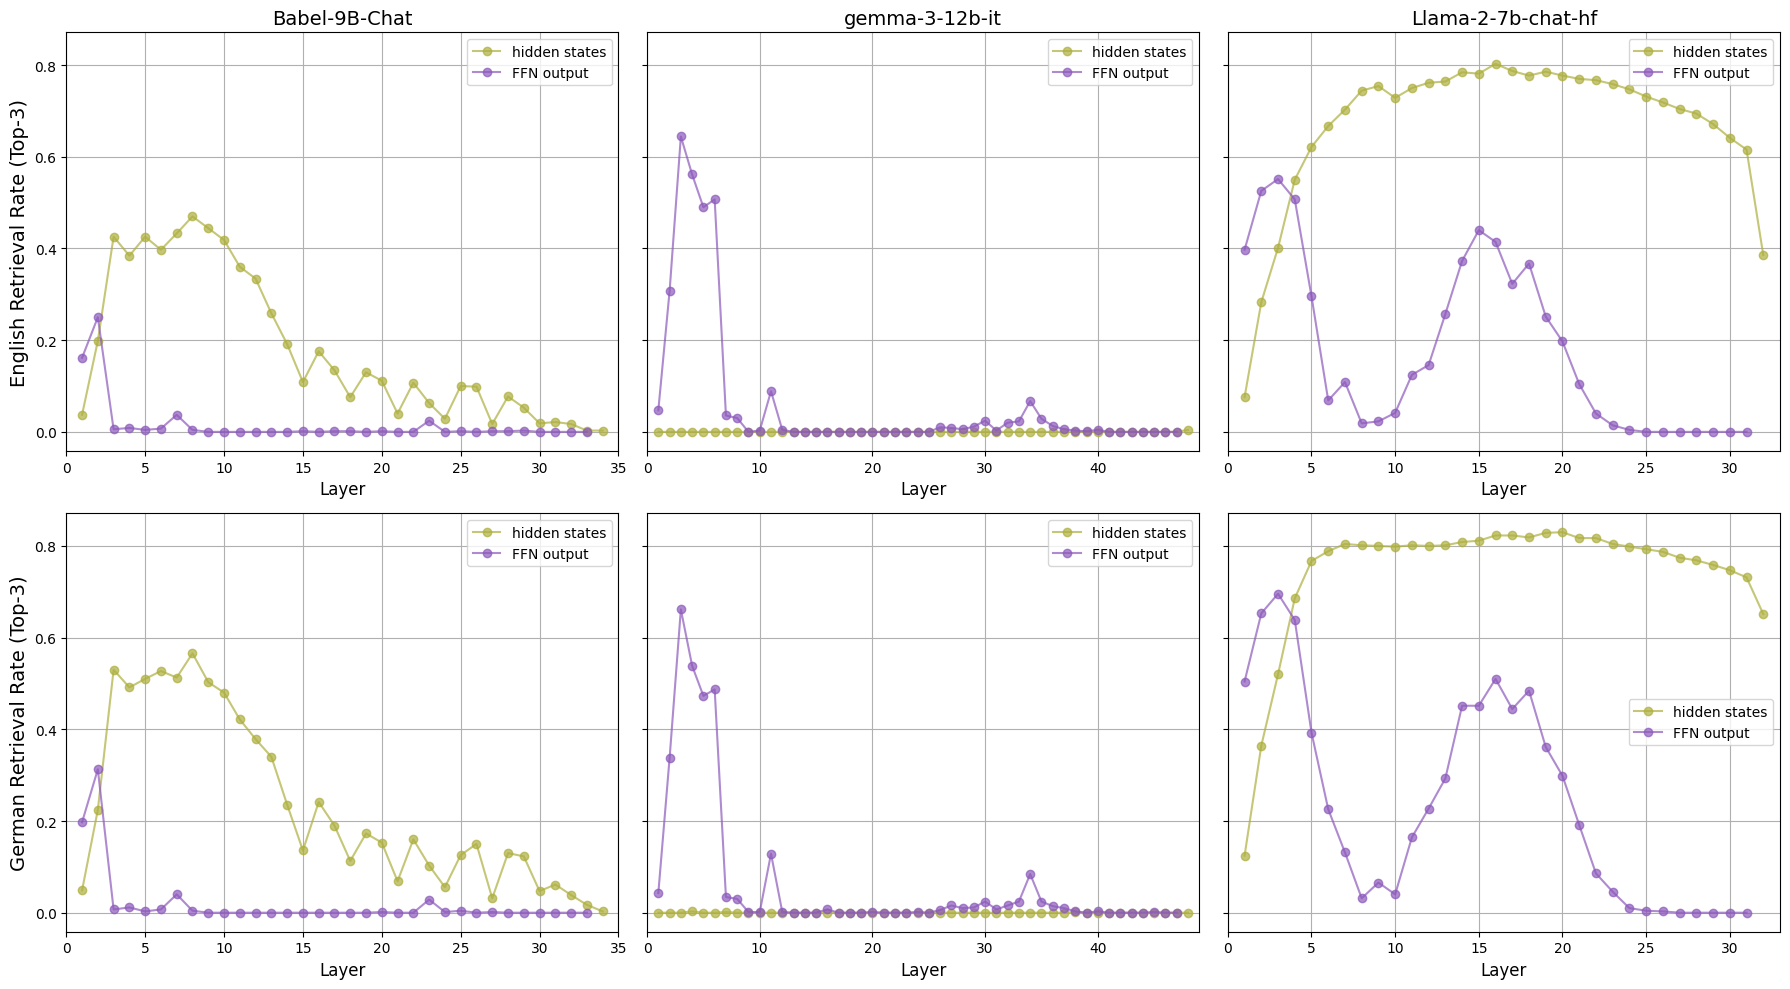

In [28]:
import ast

# Create a grid of subplots (2 rows for languages, 3 columns for models)
model_colors = {
    "Babel-9B-Chat": "#66c2a5",
    "gemma-3-12b-it": "#fc8d62",
    "Llama-2-7b-chat-hf": "#e78ac3"
}

# Define colors for each language
language_colors = {
    "English": "#1f77b4",
    "Korean": "#ff7f0e",
    "German": "#2ca02c"
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)

for col_idx, model_name in enumerate(model_colors.keys()):
    for row_idx, language in enumerate(["English", "German"]):
        # Load data
        layer_df_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordIdentity/single_token_simple_split_{model_name}_{language}_v3.csv"
        ffn_df_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/ffn_hidden_states/single_token_simple_split_{model_name}_{language}.csv"

        layer_df = pd.read_csv(layer_df_path)
        ffn_df = pd.read_csv(ffn_df_path)

        layer_df = convert_str_columns_to_lists(layer_df)
        ffn_df = convert_str_columns_to_lists(ffn_df)

        layers, retrieval_rates = get_retrieval_rates(layer_df)
        ffn_layers, ffn_retrieval_rates = get_retrieval_rates(ffn_df)

        layers, cumulative_rates = get_cumulative_retrieval_rates(layer_df)
        ffn_layers, ffn_cumulative_rates = get_cumulative_retrieval_rates(ffn_df)

        # Plot on the corresponding subplot
        ax = axes[row_idx, col_idx]
        ax.plot(layers, retrieval_rates, marker='o', label='hidden states', color="#adaf3d", alpha=0.7)
        ax.plot(ffn_layers, ffn_retrieval_rates, marker='o', label='FFN output', color="#8c59bb", alpha=0.7)

        # Set title and labels
        if row_idx == 0:
            ax.set_title(model_name, fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(f"{language} Retrieval Rate (Top-3)", fontsize=14)

        ax.set_xlabel("Layer", fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)

        # Set x-axis range dynamically based on layers
        ax.set_xlim([min(layers + ffn_layers)-1, max(layers + ffn_layers)+1])

# Adjust layout
plt.tight_layout()
plt.show()

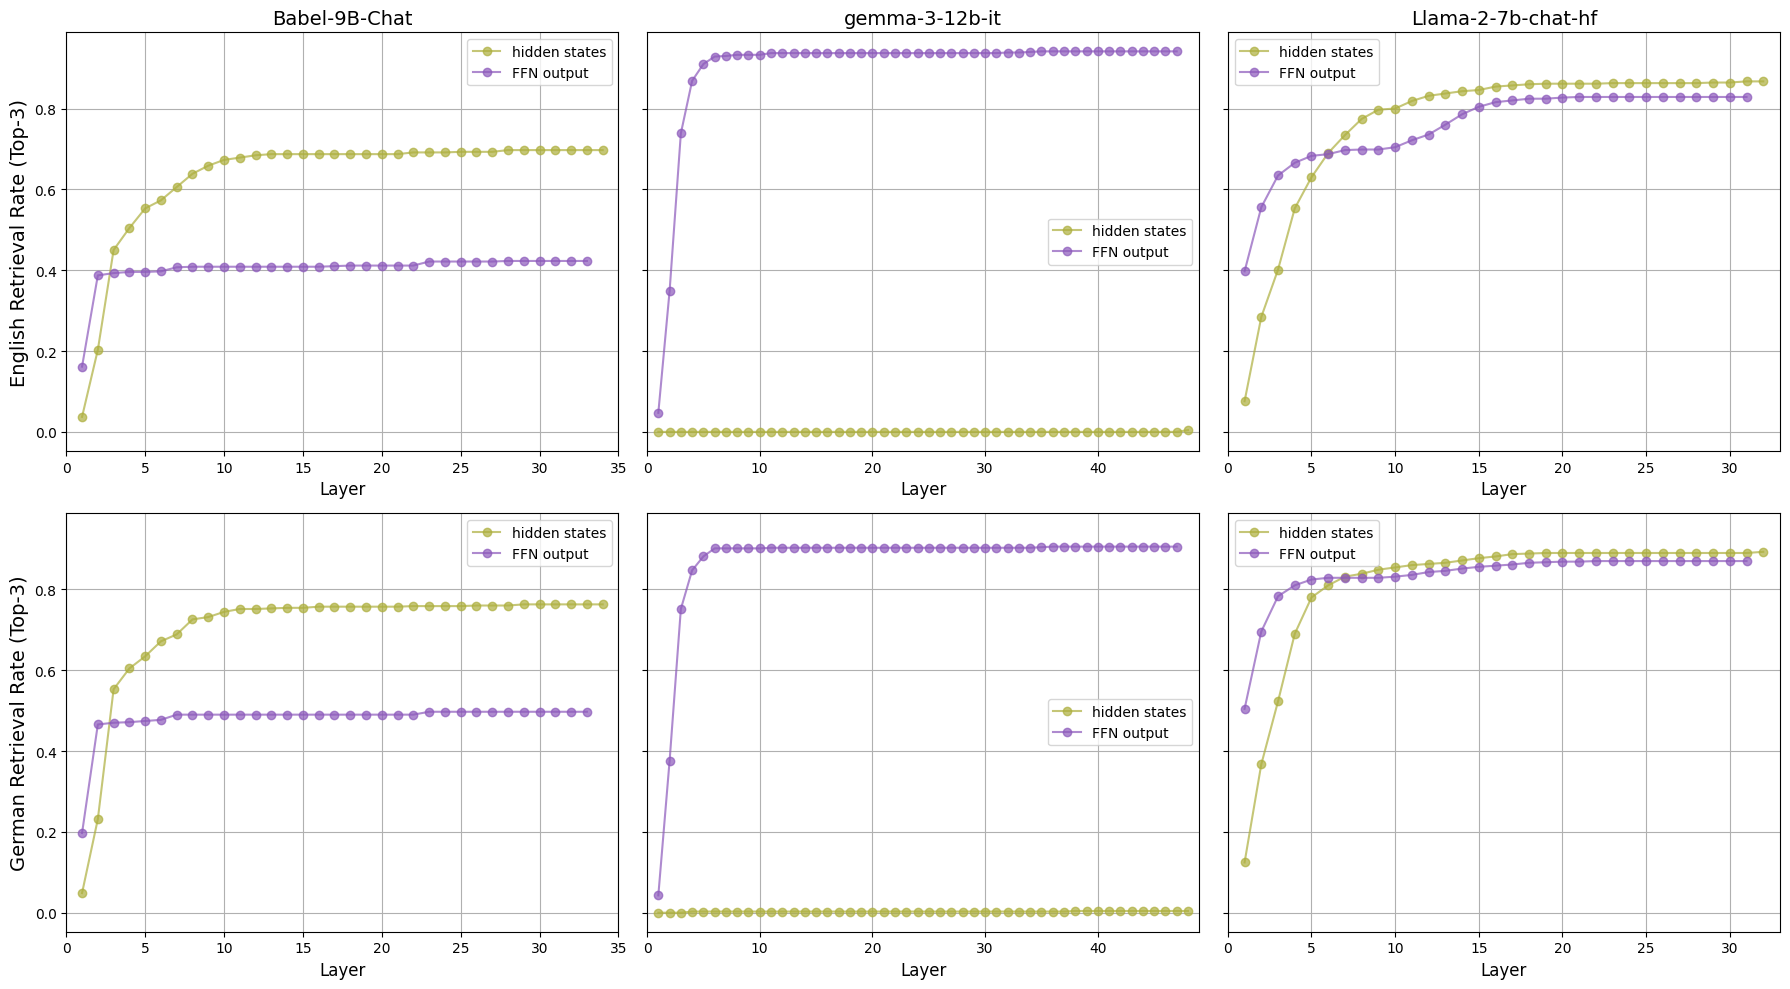

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=True)

for col_idx, model_name in enumerate(model_colors.keys()):
    for row_idx, language in enumerate(["English", "German"]):
        # Load data
        layer_df_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordIdentity/single_token_simple_split_{model_name}_{language}_v3.csv"
        ffn_df_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/ffn_hidden_states/single_token_simple_split_{model_name}_{language}.csv"

        layer_df = pd.read_csv(layer_df_path)
        ffn_df = pd.read_csv(ffn_df_path)

        layer_df = convert_str_columns_to_lists(layer_df)
        ffn_df = convert_str_columns_to_lists(ffn_df)

        layers, cumulative_rates = get_cumulative_retrieval_rates(layer_df)
        ffn_layers, ffn_cumulative_rates = get_cumulative_retrieval_rates(ffn_df)

        # Plot on the corresponding subplot
        ax = axes[row_idx, col_idx]
        ax.plot(layers, cumulative_rates, marker='o', label='hidden states', color="#adaf3d", alpha=0.7)
        ax.plot(ffn_layers, ffn_cumulative_rates, marker='o', label='FFN output', color="#8c59bb", alpha=0.7)

        # Set title and labels
        if row_idx == 0:
            ax.set_title(model_name, fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(f"{language} Retrieval Rate (Top-3)", fontsize=14)

        ax.set_xlabel("Layer", fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)

        # Set x-axis range dynamically based on layers
        ax.set_xlim([min(layers + ffn_layers)-1, max(layers + ffn_layers)+1])

# Adjust layout
plt.tight_layout()
plt.show()

In [4]:
def run_analysis(MODEL_NAME, LANGUAGE):
    # Load the dataframes
    # Adjust the paths as necessary
    layer_df = f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/WordIdentity/single_token_simple_split_{MODEL_NAME}_{LANGUAGE}_v3.csv"
    ffn_df = f"/home/hyujang/multilingual-inner-lexicon/output/RQ1/ComponentAnalysis/ffn_hidden_states/single_token_simple_split_{MODEL_NAME}_{LANGUAGE}.csv"

    layer_df = pd.read_csv(layer_df)
    ffn_df = pd.read_csv(ffn_df)

    layer_df = convert_str_columns_to_lists(layer_df)
    ffn_df = convert_str_columns_to_lists(ffn_df)

    layers, retrieval_rates = get_retrieval_rates(layer_df)
    ffn_layers, ffn_retrieval_rates = get_retrieval_rates(ffn_df)

    layers, cumulative_rates = get_cumulative_retrieval_rates(layer_df)
    ffn_layers, ffn_cumulative_rates = get_cumulative_retrieval_rates(ffn_df)

    plot_retrieval_rates(MODEL_NAME, LANGUAGE, layers, retrieval_rates, ffn_layers, ffn_retrieval_rates, retreival_type="per_layer")
    plot_retrieval_rates(MODEL_NAME, LANGUAGE, layers, cumulative_rates, ffn_layers, ffn_cumulative_rates, retreival_type="cumulative")

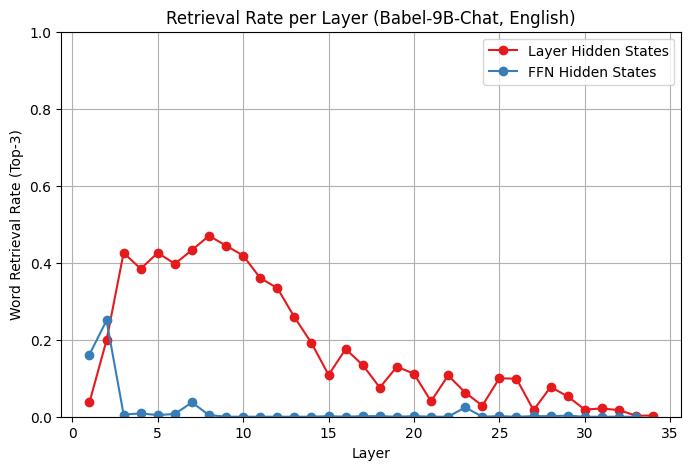

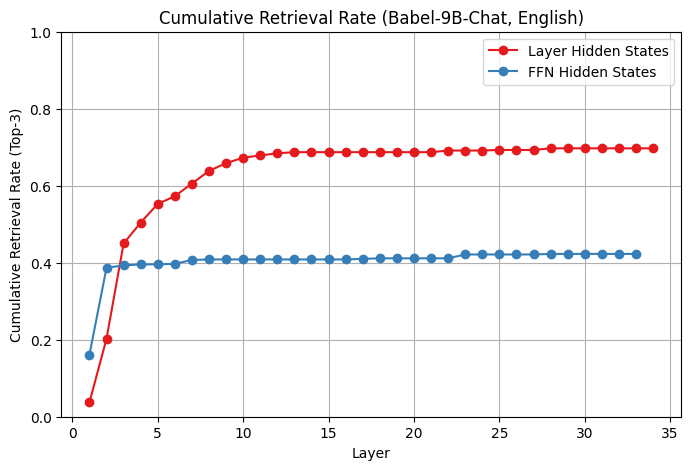

In [46]:
MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "English"

run_analysis(MODEL_NAME, LANGUAGE)

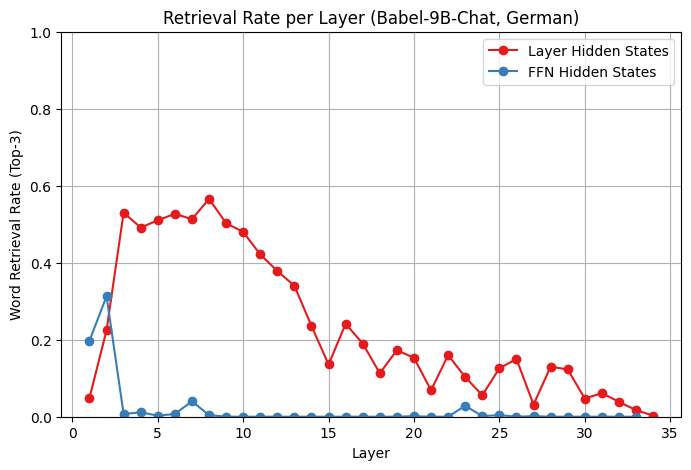

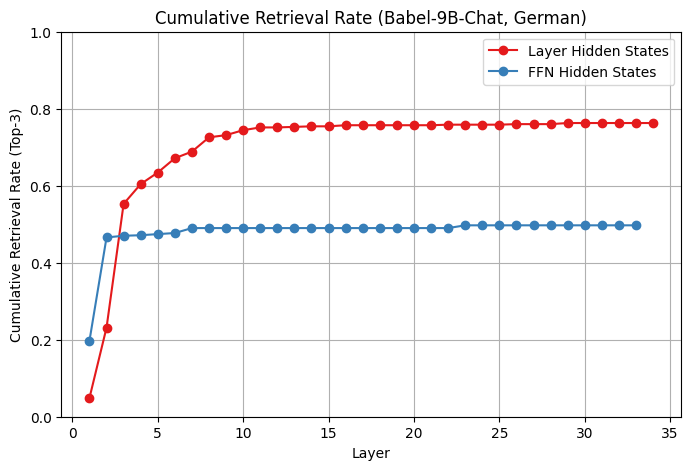

In [47]:
MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "German"

run_analysis(MODEL_NAME, LANGUAGE)

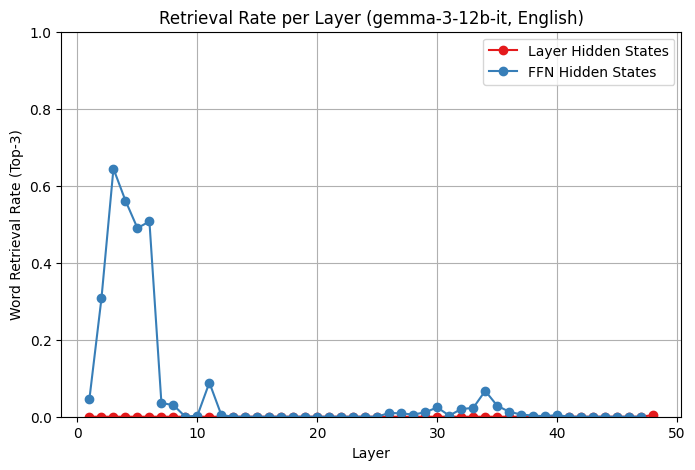

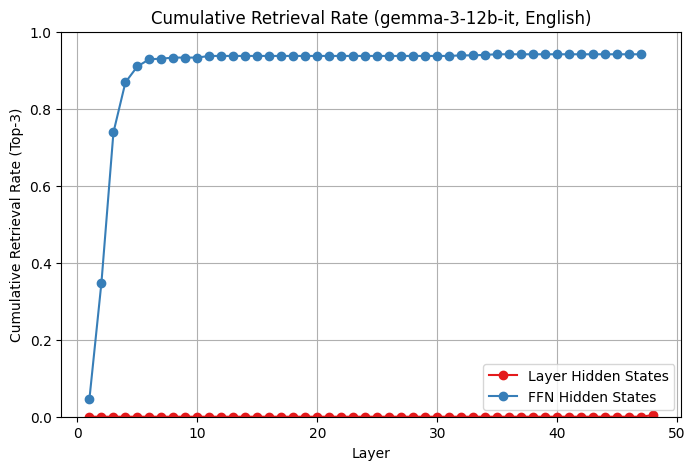

In [48]:
MODEL_NAME = "google/gemma-3-12b-it"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "English"

run_analysis(MODEL_NAME, LANGUAGE)

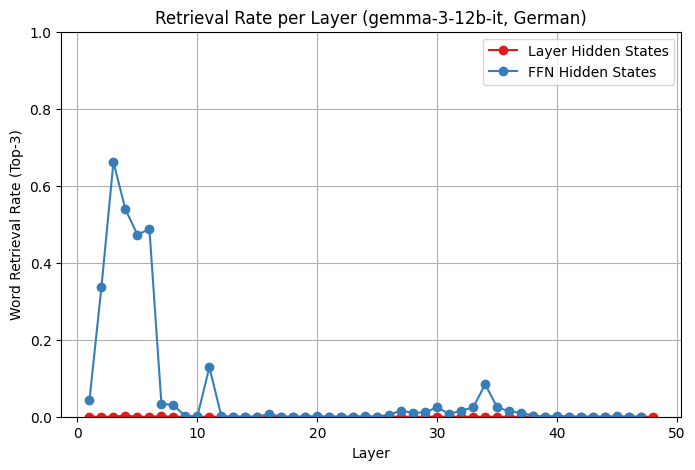

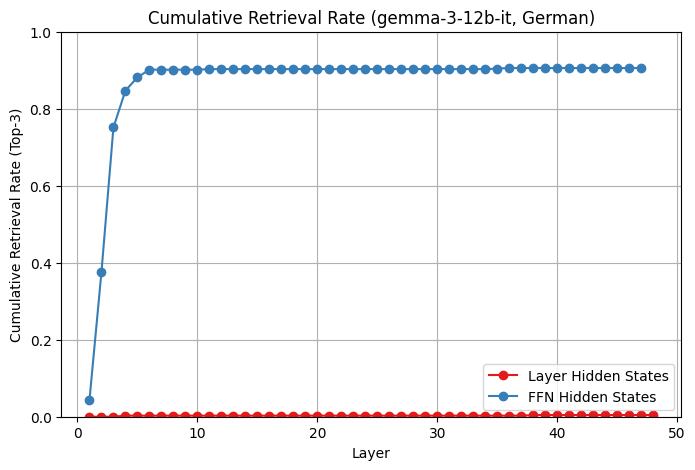

In [49]:
MODEL_NAME = "google/gemma-3-12b-it"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "German"

run_analysis(MODEL_NAME, LANGUAGE)

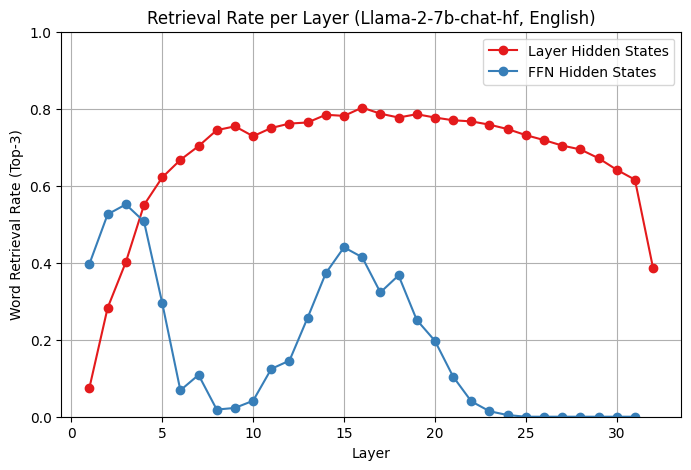

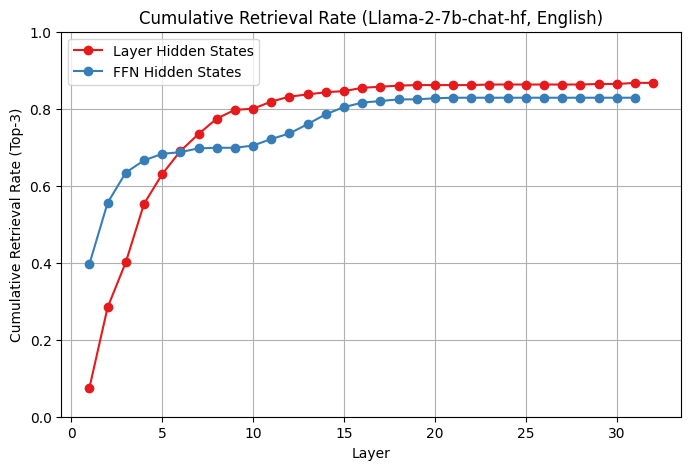

In [50]:
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "English"

run_analysis(MODEL_NAME, LANGUAGE)

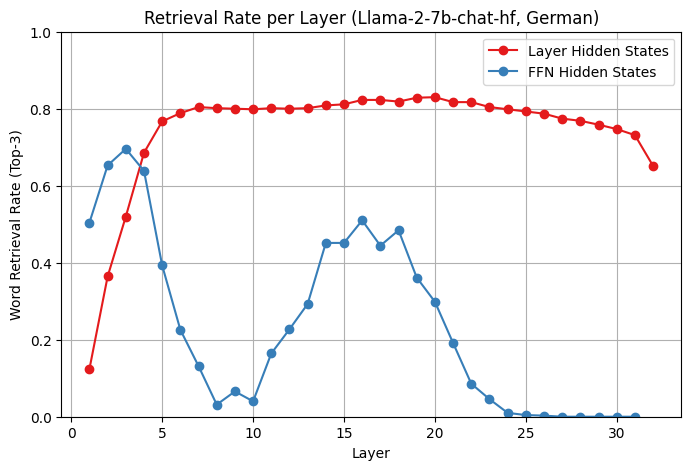

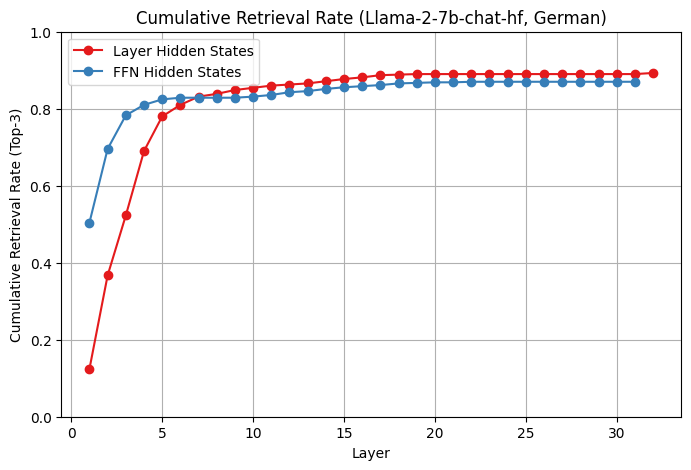

In [51]:
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
MODEL_NAME = MODEL_NAME.split("/")[-1]
LANGUAGE = "German"

run_analysis(MODEL_NAME, LANGUAGE)